# ResNets on CIFAR10

In [8]:
# Importing the Libraries
import numpy as np
import torch
from torch import nn
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt

### Helper Functions

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
def get_label_names_from_bytes_dict(x:dict) -> list:
    data = x.get(b"label_names")
    labels =  list(map(lambda m: m.decode("utf-8"),data))
    label_dict = dict()
    for i in range(10):
        label_dict.update({labels[i]: i})
    return label_dict

In [11]:
def is_my_model_under_5m_params(model):
    FIVE_MILLION = 5_000_000
    sum = 0
    for x in model.parameters():
        sum += x.numel()
    print(sum)
    if sum <= FIVE_MILLION:
        print("less than 5 million params")
    else:
        print(f"Decrease {sum - FIVE_MILLION} params!!!")

In [12]:
META_FILE_PATH = "/content/dataset/train/batches.meta"

TRAINING_FILE_PATH = "/content/dataset/train/"
VALIDATION_FILE_PATH = "/content/dataset/val/test_batch"
TEST_FILE_PATH = "/content/dataset/test/cifar_test_nolabels.pkl"

IS_LOGGING_ENABLED = True

In [14]:
# Setting the seed
torch.manual_seed(0)

In [15]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Composing multiple transformations to apply on the image when creating the dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# The validation images would only be normalized as we want to infer on it
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# loading the data

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)
val_loader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [16]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 32, layers[0])
        self.layer2 = self.make_layer(block, 64, layers[1], 2)
        self.layer3 = self.make_layer(block, 128, layers[2], 2)
        self.layer4 = self.make_layer(block, 256, layers[3], 2)
        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [3, 3, 3, 3])

In [17]:
is_my_model_under_5m_params(model)

4709914
less than 5 million params


In [18]:
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.6, inplace=False)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kern

## Model Training

In [20]:
#Try the Learning Rate Scheduler
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Choosing loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=6e-4)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

num_epochs = 150

loss_values = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    loss_values.append(running_loss/len(train_loader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/150], Loss: 2.2594
Epoch [2/150], Loss: 1.6807
Epoch [3/150], Loss: 1.3600
Epoch [4/150], Loss: 1.1162
Epoch [5/150], Loss: 0.9685
Epoch [6/150], Loss: 0.8514
Epoch [7/150], Loss: 0.7670
Epoch [8/150], Loss: 0.7117
Epoch [9/150], Loss: 0.6857
Epoch [10/150], Loss: 0.6572
Epoch [11/150], Loss: 0.6377
Epoch [12/150], Loss: 0.6246
Epoch [13/150], Loss: 0.6090
Epoch [14/150], Loss: 0.6031
Epoch [15/150], Loss: 0.5896
Epoch [16/150], Loss: 0.5837
Epoch [17/150], Loss: 0.5790
Epoch [18/150], Loss: 0.5730
Epoch [19/150], Loss: 0.5680
Epoch [20/150], Loss: 0.5562
Epoch [21/150], Loss: 0.5594
Epoch [22/150], Loss: 0.5475
Epoch [23/150], Loss: 0.5459
Epoch [24/150], Loss: 0.5400
Epoch [25/150], Loss: 0.5425
Epoch [26/150], Loss: 0.5434
Epoch [27/150], Loss: 0.5440
Epoch [28/150], Loss: 0.5340
Epoch [29/150], Loss: 0.5283
Epoch [30/150], Loss: 0.5367
Epoch [31/150], Loss: 0.3733
Epoch [32/150], Loss: 0.3200
Epoch [33/150], Loss: 0.2995
Epoch [34/150], Loss: 0.2881
Epoch [35/150], Loss: 0

# Model Training and Performance Analysis

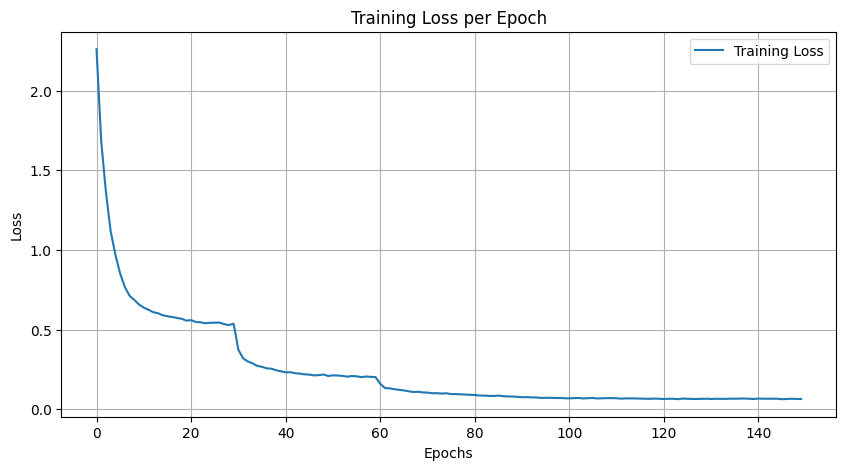

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

accuracy = 100 * correct_predictions / total_predictions
print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

Accuracy of the model on the test set: 93.14%


In [23]:
import pickle

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

cifar10_batch = load_cifar_batch('/content/dataset/test/cifar_test_nolabels.pkl')

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

images = cifar10_batch[b'data'].reshape(-1, 3, 32, 32)
ids = cifar10_batch[b'ids']
pred_labels = np.zeros(ids.shape, dtype="int32")

model = model.cuda()
model.eval()

for i in range(len(images)):
    with torch.no_grad():
        test_image = images[i]
        test_image = np.transpose(test_image, (1,2,0))
        test_image = transform_test(test_image)
        test_image = test_image.unsqueeze(0).cuda()

        pred = model(test_image)
        _, predicted = torch.max(pred, 1)
        pred_labels[i] = predicted

import pandas as pd
test_results = pd.DataFrame({'ID': ids, 'Labels': pred_labels})
test_results.to_csv('/content/dataset/result.csv', index=False)

### Saving the model weights

In [23]:
torch.save(model.state_dict(), "./model.pth")